In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import random
from scipy.special import comb
from scipy import integrate


plt.rc('font', family='serif') 
plt.rc('font', serif='Georgia') 

# Figure 1

/home/cal/bcassese/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


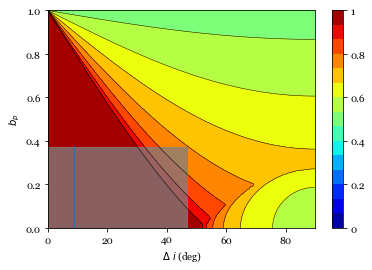

In [2]:
def transit_prob(delta_I, b_p, a_m, R_s):
    if b_p * R_s + a_m * np.abs(np.sin(delta_I)) < R_s:
        A = 0
    else:
        q = (R_s * (1 - b_p)) / (a_m * np.sin(delta_I))
        A = np.arccos(q)
        
    if b_p * R_s - a_m * np.abs(np.sin(delta_I)) > -R_s:
        B = np.pi
    else:
        q =  (-R_s * (1 + b_p)) / (a_m * np.sin(delta_I))
        B = np.arccos(q)
        
    return (B - A) / np.pi


R_s = 1
Xs = np.linspace(0,90*np.pi/180,300)
Ys = np.linspace(0,1,100)
Zs = []
for x in Xs:
    for y in Ys:
        Zs.append(transit_prob(x, y, a_m=(11.7+3.9)*0.0818, R_s=1))
Zs = np.array(Zs)

fig, ax = plt.subplots()
ax.contour(Xs*180/np.pi, Ys, Zs.reshape((len(Xs), len(Ys))).T, 
             levels=np.linspace(0,1,16), linewidths=[0.5], colors='k', vmin=0, vmax=1)
a = ax.contourf(Xs*180/np.pi, Ys, Zs.reshape((len(Xs), len(Ys))).T, 
             levels=np.linspace(0,1,16), vmin=0, vmax=1,
             cmap='jet')#,  extend='both')
ax.set(xlabel='$\Delta \, \, i$ (deg)', ylabel='$b_p$', xlim=(0,90))
c = fig.colorbar(a, ax=ax)
c.set_ticks(np.linspace(0,1,6))
_=c.ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])


ax.fill_between(np.linspace(0,47,10), np.zeros(10), np.ones(10)*0.37,
                color='grey', alpha=0.75)
ax.plot([9,9], [0,0.37])
# plt.savefig('hide_and_seek.pdf')
# ax.errorbar([9], [])

# Figure 2

In [2]:
def planet_location(planet_radius, duration, time, b):
    return np.array([(2*np.sqrt((1+planet_radius)**2 - b**2)) \
        / duration * time - np.sqrt((1+planet_radius)**2 - b**2),
                     np.ones(len(time))*b])
def moon_orbit_planet_centered(am, phi, Omega, i):
    return am*np.array([np.cos(phi)*np.cos(np.deg2rad(Omega)) - \
            np.cos(np.deg2rad(i))*np.sin(phi)*np.sin(np.deg2rad(Omega)),
        np.cos(np.deg2rad(i))*np.cos(np.deg2rad(Omega))*np.sin(phi) + \
            np.cos(phi)*np.sin(np.deg2rad(Omega))])

def moon_phase(start_phase, moon_period, duration, time,
               am, b, planet_radius):
    return start_phase + (2*np.pi/moon_period)*(time + 
            (np.sqrt((1+am)**2 - b**2) - 
                np.sqrt((1+planet_radius)**2 - b**2)) / 
            (2*np.sqrt((1+planet_radius)**2 - b**2) / duration))

def moon_location(planet_radius, duration, time, b, start_phase,
                 am, moon_period, Omega, i):
    return planet_location(planet_radius, duration, time, b) \
            +  moon_orbit_planet_centered(
                    am, 
                    moon_phase(start_phase, moon_period, 
                               duration, time, am, b, planet_radius),
                    Omega, i)

def moon_distance(planet_radius, duration, time, b, start_phase,
                 am, moon_period, Omega, i):
    return np.sqrt( np.sum(moon_location(planet_radius, duration, time, b, start_phase,
                 am, moon_period, Omega, i)**2, axis=0) )

def velocity(planet_radius, b, duration):
    return 2*np.sqrt((1+planet_radius)**2 - b**2) / duration

def extra_time(Omega, am, b, planet_radius, duration):
    return (np.sqrt((1+am)**2 - b**2) - 
           np.sqrt((1+planet_radius)**2 - b**2)) / \
            (2*np.sqrt((1+planet_radius)**2 - b**2) / duration)


def transit_chances(planet_radius, moon_radius, duration, times, b,
                    am, moon_period, Omega, i):
    
    p = planet_location(planet_radius, duration, times, b)
    s_seps = np.zeros(1000)
    p_seps = np.zeros(1000)
    ind = 0
    for phase in np.linspace(0, 2*np.pi, 1000):
        s = moon_location(planet_radius,
                          duration, times, b, phase,
                          am, moon_period, Omega, i)
        moon_planet_sep = np.sqrt((s[0,((times > 0) & (times < duration))] - \
                                    p[0,((times > 0) & (times < duration))])**2 + \
                                  (s[1,((times > 0) & (times < duration))] - \
                                    p[1,((times > 0) & (times < duration))])**2)
        moon_star_sep = np.sqrt( np.sum(s**2, axis=0) )
        s_seps[ind] = np.min(moon_star_sep)
        p_seps[ind] = np.min(moon_planet_sep)
        ind+=1

    full_transit = s_seps < (1-moon_radius)
    grazing_only = (s_seps < (1+moon_radius)) & ~full_transit

    full_mutual = p_seps < (planet_radius-moon_radius)
    grazing_only_mutual = (p_seps < (planet_radius+moon_radius)) & ~full_mutual
    
    return {'Full Transit':np.sum(full_transit)/1000,
           'Grazing Transit':np.sum(grazing_only)/1000,
           'Full Mutual':np.sum(full_mutual)/1000,
           'Grazing Mutual':np.sum(grazing_only_mutual)/1000}

In [31]:
planet_radius = 0.0818
moon_period=4.6*24
moon_radius = 0.263*0.0818
am=11.7*0.0818

duration = 19.13
times = np.linspace(0, duration, 1000)


def temp(i, period):
    return transit_chances(planet_radius=planet_radius,
                    moon_radius=moon_radius,
                    duration=duration,
                    times=times,
                    b=0,
                    am=am,
                    moon_period=period,
                    Omega=0,
                    i=i)

odds1 = []
Is = 90 - np.linspace(0,20,300)[::-1]
for i in tqdm(Is):
    odds1.append(temp(i, 4.6*24))
    
odds2 = []
Is = 90 - np.linspace(0,20,300)[::-1]
for i in tqdm(Is):
    odds2.append(temp(i, (4.6+3.1)*24))
    
odds3 = []
Is = 90 - np.linspace(0,20,300)[::-1]
for i in tqdm(Is):
    odds3.append(temp(i, (4.6-1.8)*24))

100%|██████████| 300/300 [00:29<00:00, 10.14it/s]


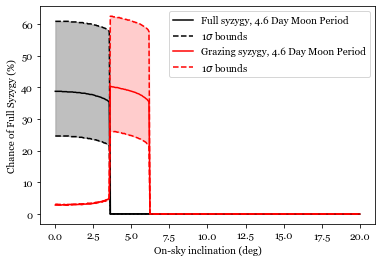

In [41]:
d1 = pd.DataFrame(odds1)
full1 = d1['Full Mutual']
p1 = d1['Grazing Mutual']

d2 = pd.DataFrame(odds2)
full2 = d2['Full Mutual']
p2 = d2['Grazing Mutual']

d3 = pd.DataFrame(odds3)
full3 = d3['Full Mutual']
p3 = d3['Grazing Mutual']


fig, ax = plt.subplots()
x = -334
ax.plot((90-Is)[:x:-1], full1[:x:-1]*100, color='k', label='Full syzygy, 4.6 Day Moon Period')
ax.plot((90-Is)[:x:-1], full2[:x:-1]*100, color='k', label='1$\sigma$ bounds', linestyle='--')
ax.plot((90-Is)[:x:-1], full3[:x:-1]*100, color='k', linestyle='--')
ax.fill_between((90-Is)[:x:-1], full2[:x:-1]*100, full3[:x:-1]*100, color='grey', alpha=0.5)


ax.plot((90-Is)[:x:-1], p1[:x:-1]*100, color='r', label='Grazing syzygy, 4.6 Day Moon Period')
ax.plot((90-Is)[:x:-1], p2[:x:-1]*100, color='r', label='1$\sigma$ bounds', linestyle='--')
ax.plot((90-Is)[:x:-1], p3[:x:-1]*100, color='r', linestyle='--')
ax.fill_between((90-Is)[:x:-1], p2[:x:-1]*100, p3[:x:-1]*100, color='r', alpha=0.2)

ax.legend()

ax.set(xlabel='On-sky inclination (deg)', ylabel='Chance of Full Syzygy (%)')
plt.savefig('syzygy.pdf')

In [42]:
print(90 - np.arccos((planet_radius-moon_radius)/am) * 180/np.pi)
print(90 - np.arccos((planet_radius+moon_radius)/am) * 180/np.pi)

3.6115354749603625
6.197081608471009


In [21]:
# Sampling chances
post = np.loadtxt('/home/cal/bcassese/Google Drive/Columbia University/Research/Data/LRVmoon-post_equal_weights.dat')

def temp(i, period):
    return transit_chances(planet_radius=planet_radius,
                    moon_radius=moon_radius,
                    duration=duration,
                    times=times,
                    b=0,
                    am=am,
                    moon_period=period,
                    Omega=0,
                    i=i)

q = Parallel(n_jobs=-1)(delayed(temp)((np.arccos(x[10]))*180/np.pi - 90,
                                                    x[7]) for x in tqdm(post))

d = pd.DataFrame(q)[~np.isnan(np.arccos(post[:,10]))].copy()
print(len(d[d['Full Mutual'] > 0]) / len(d))
print(len(d[d['Grazing Mutual'] > 0]) / len(d))

0.0014619883040935672
0.003498329156223893


/home/cal/bcassese/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


# Figure 3

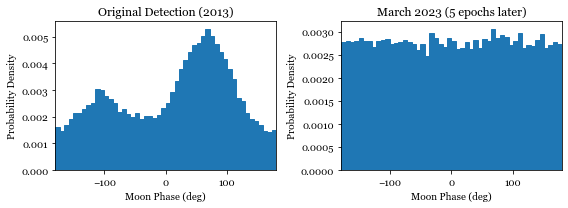

In [14]:
post = np.loadtxt('/home/cal/bcassese/Google Drive/Columbia University/Research/Data/LRVmoon-post_equal_weights.dat')

def new_phases(epochs):
    initial_angles = post[:,9]*180/np.pi + 180
    additional_phase = ((post[:,3]*epochs / post[:,7]) - np.floor(post[:,3]*epochs / post[:,7])) * 360
    return ((initial_angles + additional_phase) % 360) - 180

fig, ax = plt.subplots(ncols=2, figsize=(8,3))
_=ax[0].hist(new_phases(0), bins=50, density=True, edgecolor='C0')
ax[0].set(xlabel='Moon Phase (deg)', ylabel='Probability Density',
          title='Original Detection (2013)', xlim=(-180, 180))

_=ax[1].hist(new_phases(5), bins=50, density=True, edgecolor='C0')
ax[1].set(xlabel='Moon Phase (deg)', ylabel='Probability Density',
          title='March 2023 (5 epochs later)', xlim=(-180, 180))
plt.tight_layout()
plt.savefig('expected_phase.pdf')

# Figure 5

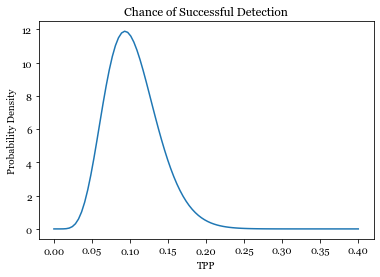

In [12]:
m = 7
n = 75
x = np.linspace(0,0.4,100)
fig, ax = plt.subplots()
ax.plot(x, (1+n)*(1-x)**(n-m)*x**m * comb(n,m)) # It already integrates to 1
ax.set(xlabel='TPP', ylabel='Probability Density',
       title='Chance of Successful Detection')
plt.savefig('tpp.pdf')